In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import tensorflow.lite as tflite

import glob


# Parameters
dataset_url = r'C:\Users\abudh\Desktop\CropWatch\EuroSAT1\2750'
batch_size = 50
img_height = 64
img_width = 64
validation_split = 0.2
rescale = 1.0 / 255
no_epochs = 1

# Data Augmentation and Loading
datagen = ImageDataGenerator(
    rescale=rescale,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    fill_mode='nearest',
    validation_split=validation_split
)

train_dataset = datagen.flow_from_directory(
    directory=dataset_url,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
    class_mode='categorical'
)

test_dataset = datagen.flow_from_directory(
    directory=dataset_url,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation",
    class_mode='categorical'
)

# Compute class weights
class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())
class_indices = list(class_indices.values())
class_counts_dict = {class_name: len(glob.glob(os.path.join(dataset_url, class_name, '*'))) for class_name in class_labels}
class_counts = np.array([class_counts_dict[class_name] for class_name in class_labels])
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_indices),
    y=np.array([train_dataset.classes[i] for i in range(len(train_dataset.classes))])
)
class_weight_dict = dict(zip(class_labels, weights))

# Define the ResNet50 model
def identity_block(X, f, filters, training=True, initializer=glorot_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X, training=training)
    return X

def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def ResNet50(input_shape=(64, 64, 3), classes=len(class_labels)):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=X)
    return model

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    verbose=1,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=1,
    restore_best_weights=True
)

model_path = r'C:\Users\abudh\Desktop\CropWatch'


# Corrected file paths to end with `.weights.h5`
dynamic_checkpoint_callback = ModelCheckpoint(
    filepath=model_path + r'\Training_model_epoch_13_08{epoch:02d}.weights.h5',  # Use .weights.h5 extension
    save_freq='epoch',
    save_weights_only=True,
    verbose=1
)

best_model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path + r'\best_weights_13_08.weights.h5',  # Use .weights.h5 extension
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Load and compile the model
model = ResNet50(input_shape=(img_height, img_width, 3), classes=len(class_labels))
model.load_weights(r'C:\Users\abudh\Desktop\CropWatch\13_08_model.h5')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_dataset,
    epochs=no_epochs,
    validation_data=test_dataset,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping, dynamic_checkpoint_callback, best_model_checkpoint_callback]
)








Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


C:\Users\abudh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8977 - loss: 0.2923
Epoch 1: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoch_13_0801.weights.h5

Epoch 1: val_loss improved from inf to 1.20811, saving model to C:\Users\abudh\Desktop\CropWatch\best_weights_13_08.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8979 - loss: 0.2916 - val_accuracy: 0.5000 - val_loss: 1.2081 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


In [11]:
# Convert the model to TFLite
model.save( r'C:\Users\abudh\Desktop\CropWatch\13_08_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = r'C:\Users\abudh\Desktop\CropWatch\13_08_retrained_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")




INFO:tensorflow:Assets written to: C:\Users\abudh\AppData\Local\Temp\tmpsyf3i48a\assets


INFO:tensorflow:Assets written to: C:\Users\abudh\AppData\Local\Temp\tmpsyf3i48a\assets


Saved artifact at 'C:\Users\abudh\AppData\Local\Temp\tmpsyf3i48a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_1012')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1891468421520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891468422096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1894889457616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1894889457808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891468416720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891468420752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1894889458576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1894889458000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1894889457424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1890969042000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  18

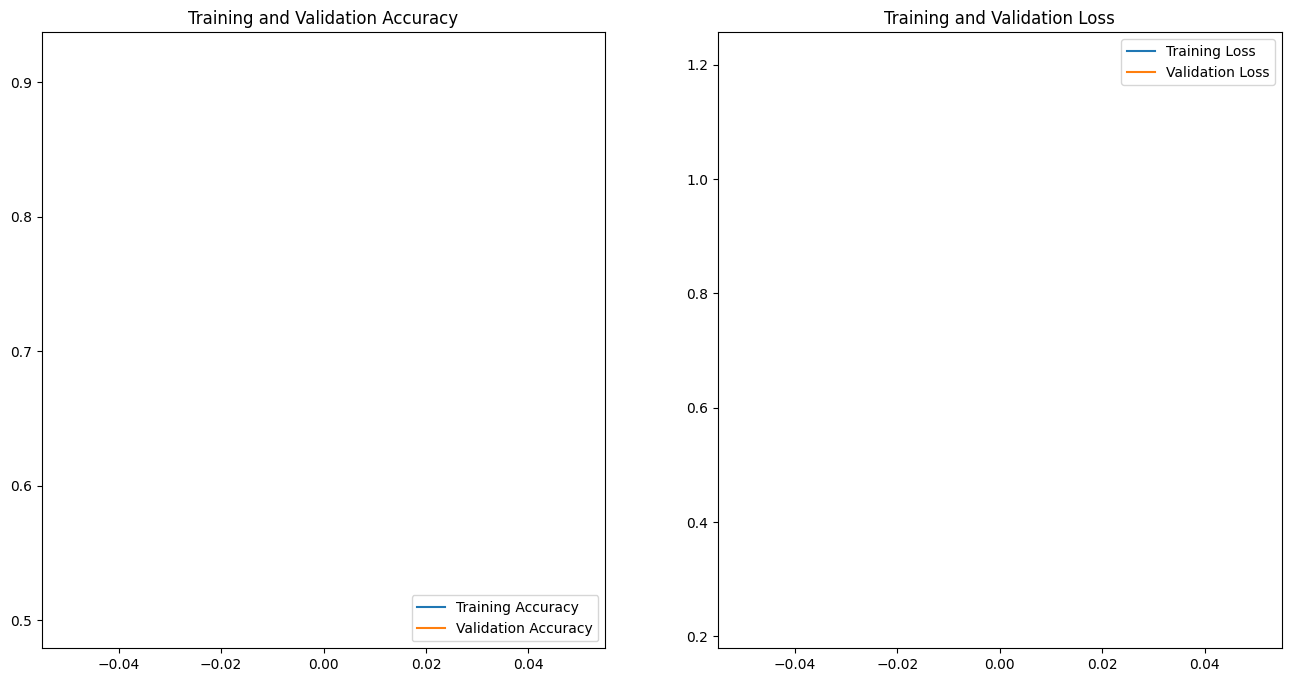

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step


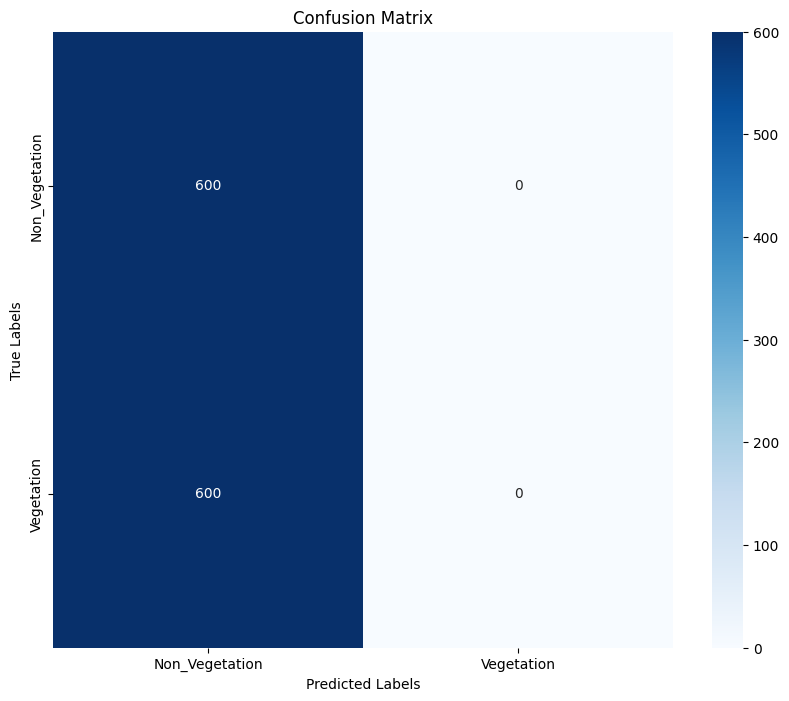

In [12]:
# Evaluate and visualize
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

# Confusion Matrix
preds = model.predict(test_dataset)
preds_labels = np.argmax(preds, axis=1)
true_labels = test_dataset.classes

cm = confusion_matrix(true_labels, preds_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()